<a href="https://colab.research.google.com/github/saachi-surana/UW-PHYS417/blob/main/Night_5_27_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finger Flexions using EEG Data

Model type: ShallowFBSCP

Multi-classification problem, where EEG brain signals will be used to predict the specific finger that is flexed.


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
#load the mat files
mat=scipy.io.loadmat('bp_fingerflex.mat')
mat1=scipy.io.loadmat('bp_stim.mat')
stim = mat1['stim']

# Data Exploration and Visualizations

In [32]:
# prompt: show elements of the bp_fingerflex and values show entire table

# Display the entire dictionary structure and values
# Check the available keys in the dictionary
print("Available keys in the mat dictionary:", mat.keys())

print(mat)

print("Values of mat")

for key, value in mat.items():
    print(f"{key}: {value}")


print("Available keys in the mat1 dictionary:", mat1.keys())
print(mat1)

for key, value in mat1.items():
    print(f"{key}: {value}")


Available keys in the mat dictionary: dict_keys(['__header__', '__version__', '__globals__', 'data', 'elec_regions', 'flex', 'brain', 'locs', 'cue'])
{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Mon Jan  4 09:05:12 2016', '__version__': '1.0', '__globals__': [], 'data': array([[-1815,  -152,  2584, ..., -1141, -3628, -2069],
       [-1744,   133,  2700, ..., -1193, -3495, -1944],
       [-1776,   255,  2596, ..., -1392, -3538, -2042],
       ...,
       [ -886,  4676,  3588, ..., -1912, -6479,  -243],
       [ -969,  4812,  3748, ..., -1844, -6411,  -142],
       [-1235,  4821,  3671, ..., -1891, -6498,  -135]], dtype=int32), 'elec_regions': array([[6],
       [6],
       [6],
       [6],
       [6],
       [0],
       [1],
       [3],
       [6],
       [6],
       [6],
       [6],
       [1],
       [3],
       [3],
       [6],
       [6],
       [6],
       [6],
       [0],
       [2],
       [3],
       [7],
       [6],
       [6],
       [6],
       [6],
   

In [33]:
import numpy as np

stim = mat1['stim']  # replace 'mat' with your loaded dictionary if needed
unique_values, counts = np.unique(stim, return_counts=True)

for val, count in zip(unique_values, counts):
    print(f"Stimulus {val}: {count} occurrences")


Stimulus -2: 3786 occurrences
Stimulus -1: 88470 occurrences
Stimulus 0: 225325 occurrences
Stimulus 1: 68830 occurrences
Stimulus 2: 57013 occurrences
Stimulus 3: 57714 occurrences
Stimulus 4: 52735 occurrences
Stimulus 5: 56167 occurrences


## Key Terms:

- header: description of the MATLAB file format
- version: version of MATLAB file
- globals: global variables defined when file saved (none)

## Terms that Matter for Model

- data: main dataset, with EEG + time-sample data
  - (n_samples, n_channels)
- elec_regions: labels for each electrode, indicating brain region (frontal, occipital...)
  - [n_channels, 1], with integers like [6], [3], [1], each representing a region
- flex: time-varying flex sensor data
  - [n_samples, 5], five sensors measuring over time
- brain: brain surface geometry (3D visualization)
  - vertices: 3D coordinates of points on the brain surface.
  - faces: Indices forming triangles between vertices to make a mesh
- loc: 3D coordinates of electrode positions on the scalp
  - [n_channels, 3], (x, y, z)
- cue: stimulus conditions or task cues
  - [n_samples, 1]
- stim: values from -2 to 5, indicate type of stimulus






Stimulus:
- 0: Thumb (or rest)
- 1: Index finger
- 2: Middle finger
- 3: Ring finger
- 4: Pinky finger

In [34]:
import scipy.io, numpy as np
mat = scipy.io.loadmat('bp_fingerflex.mat', squeeze_me=True, struct_as_record=False)

data  = mat['data']          # (N_time, N_elec)  – already band-passed?
flex  = mat['flex']          # (N_time, 5)       – dataglove values
# Access cue directly as it is likely 1D due to squeeze_me=True
cue   = mat['cue']     # (N_time,)         – 0 = rest, 1-5 finger
locs  = mat['locs']          # (N_elec, 3)       – xyz in MRI space
sfreq = 1000.                # Hz  (check if your file stores it elsewhere)

print(data.shape, flex.shape, cue.shape)

(610040, 46) (610040, 5) (610040,)


Data shape: (610040, 46)
Flex shape: (610040, 5)
Cue shape: (610040,)
Stim shape: (610040,)
Sampling frequency: 1000.0 Hz
Stimulus -2: 3786 occurrences
Stimulus -1: 88470 occurrences
Stimulus 0: 225325 occurrences
Stimulus 1: 68830 occurrences
Stimulus 2: 57013 occurrences
Stimulus 3: 57714 occurrences
Stimulus 4: 52735 occurrences
Stimulus 5: 56167 occurrences
Creating RawArray with float64 data, n_channels=46, n_times=610040
    Range : 0 ... 610039 =      0.000 ...   610.039 secs
Ready.
<RawArray | 46 x 610040 (610.0 s), ~214.1 MiB, data loaded>
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition ban

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    1.2s finished



Preprocessing complete! The 'dataset' object has been modified in place.
Number of datasets in the concatenated dataset: 1


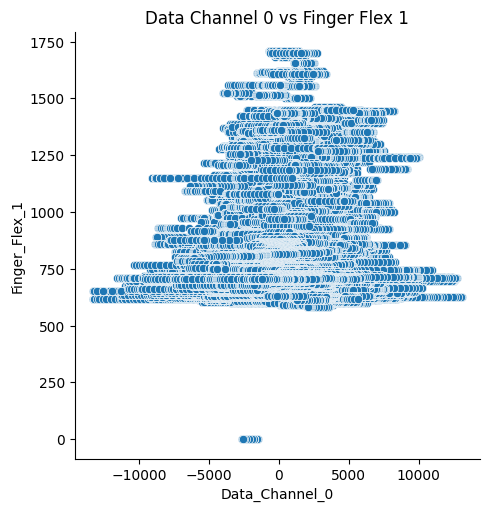

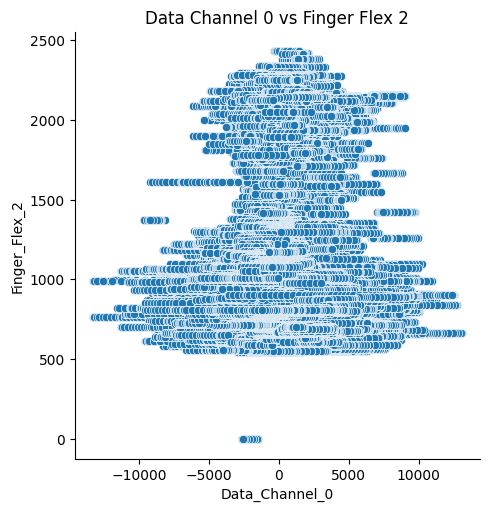

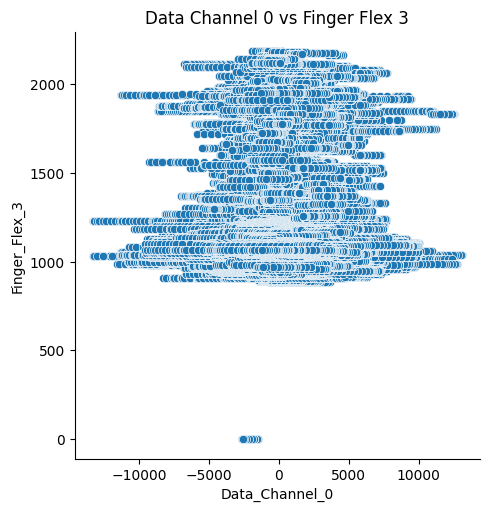

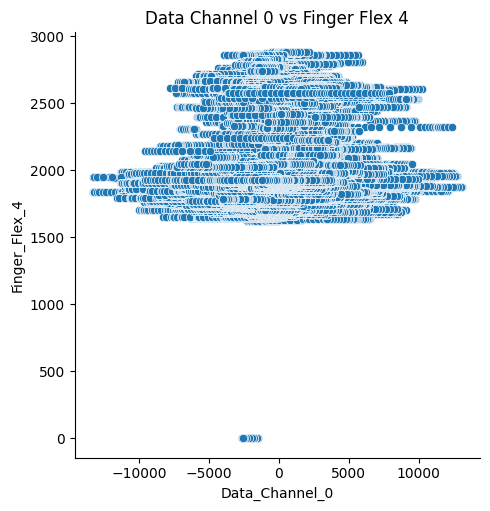

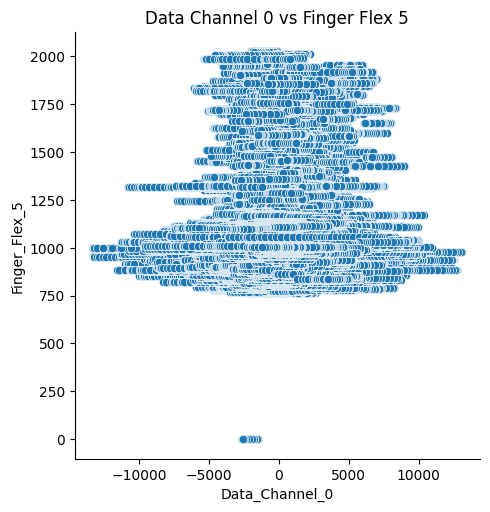

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mne # Import MNE for handling neurophysiological data
from braindecode.preprocessing import (
    exponential_moving_standardize, preprocess, Preprocessor)
from braindecode.datasets import BaseDataset, BaseConcatDataset # Import braindecode dataset classes

# --- Load the .mat files ---
mat = scipy.io.loadmat('bp_fingerflex.mat', squeeze_me=True, struct_as_record=False)
mat1 = scipy.io.loadmat('bp_stim.mat', squeeze_me=True, struct_as_record=False)

stim = mat1['stim'] # Ensure 'stim' is loaded if used elsewhere

# Extract relevant data from bp_fingerflex.mat
data = mat['data']  # (N_time, N_elec)
flex = mat['flex']  # (N_time, 5)
cue = mat['cue']    # (N_time,)
locs = mat['locs']  # (N_elec, 3)
sfreq = 1000.       # Hz (sampling frequency)

# Print initial data shapes for verification
print(f"Data shape: {data.shape}")
print(f"Flex shape: {flex.shape}")
print(f"Cue shape: {cue.shape}")
print(f"Stim shape: {stim.shape}")
print(f"Sampling frequency: {sfreq} Hz")

# Optional: Print unique stimulus values and their counts (from your original code)
unique_values, counts = np.unique(stim, return_counts=True)
for val, count in zip(unique_values, counts):
    print(f"Stimulus {val}: {count} occurrences")

# --- MNE and Braindecode Data Preparation ---

# Define channel names and types for MNE Info object
n_channels = data.shape[1]
ch_names = [f'ECoG {i+1}' for i in range(n_channels)]
ch_types = ['ecog'] * n_channels # Assuming ECoG data

# Create MNE Info object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Create MNE RawArray object from your data
# MNE expects data in (n_channels, n_times) format, so transpose your 'data' array
raw = mne.io.RawArray(data.T, info)

print(raw) # Display basic info about the created MNE Raw object

# Wrap the MNE RawArray into a braindecode BaseDataset
# For continuous data, 'y' can be None as labels aren't strictly required at this stage.
single_braindecode_dataset = BaseDataset(raw)

# Then, wrap this single BaseDataset into a BaseConcatDataset.
# The `preprocess` function expects a BaseConcatDataset for consistent handling.
dataset = BaseConcatDataset([single_braindecode_dataset])

# --- Braindecode Preprocessing Setup ---
# Define parameters for filtering and standardization
low_cut_hz = 1.   # Low cut frequency for bandpass filter (e.g., to remove slow drifts)
high_cut_hz = 200. # High cut frequency for bandpass filter (relevant for ECoG high gamma)
factor_new = 1e-3  # Adaptation factor for exponential moving standardization
init_block_size = 1000 # Initial samples for standardization statistics

# Define the preprocessing steps
preprocessors = [
    Preprocessor('pick_types', ecog=True), # Pick only ECoG channels
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz), # Apply bandpass filter
    Preprocessor(exponential_moving_standardize, # Apply exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

# Apply the preprocessors to your dataset
preprocess(dataset, preprocessors)

print("\nPreprocessing complete! The 'dataset' object has been modified in place.")
print(f"Number of datasets in the concatenated dataset: {len(dataset.datasets)}")

# How to access the preprocessed data:
# The data is now stored within the 'raw' attribute of the first dataset in the 'dataset' object.
# preprocessed_raw_data = dataset.datasets[0].raw.get_data()
# print(f"Shape of the preprocessed raw data for the first dataset: {preprocessed_raw_data.shape}")
# print(f"First 5 samples of preprocessed data (first channel):\n{preprocessed_raw_data[0, :5]}")

# --- Optional: Original plotting code (if needed for visualization) ---
# Check if the number of time points match for plotting
if data.shape[0] == flex.shape[0]:
    df_combined = pd.DataFrame()

    # Using original data for plotting here. If you want to plot preprocessed data,
    # replace 'data[:, 0]' with 'dataset.datasets[0].raw.get_data()[0, :]'
    df_combined['Data_Channel_0'] = data[:, 0]

    for i in range(flex.shape[1]):
        df_combined[f'Finger_Flex_{i+1}'] = flex[:, i]

    for i in range(flex.shape[1]):
        finger_col_name = f'Finger_Flex_{i+1}'
        sns.relplot(data=df_combined, x='Data_Channel_0', y=finger_col_name)
        plt.title(f'Data Channel 0 vs Finger Flex {i+1}')
        plt.show()
else:
    print("Error: 'data' and 'flex' arrays have different numbers of time points.")

# --- Original code for deleting keys (if still relevant) ---
# This part might not be strictly necessary if you load the data directly into variables as above
# mat = scipy.io.loadmat('bp_fingerflex.mat') # Reload if you need to modify 'mat' directly
# keys_to_delete = ['__header__', '__version__', '__globals__', 'brain']
# for key in keys_to_delete:
#     if key in mat:
#         del mat[key]
# print(mat.keys()) # Print remaining keys

In [36]:
!pip install seaborn
!pip install pandas
import seaborn as sns
import pandas as pd


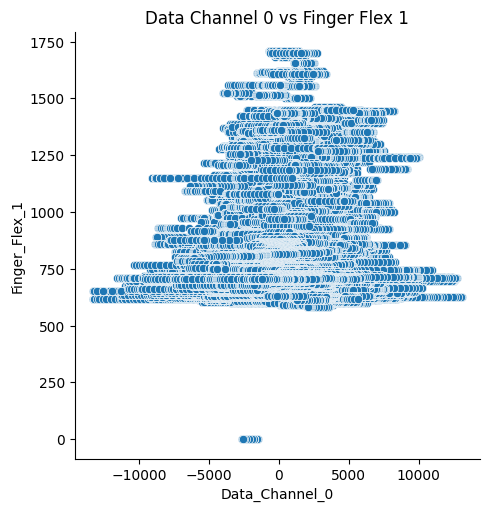

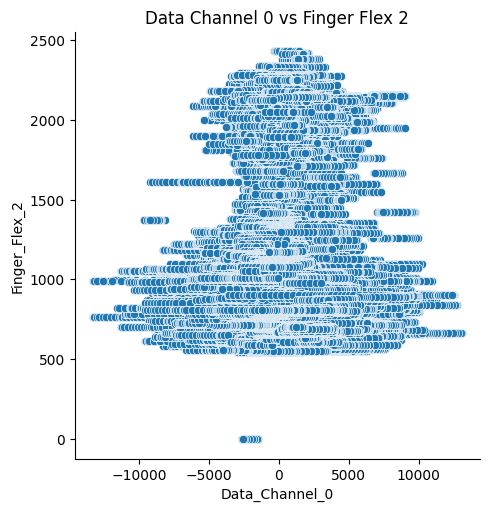

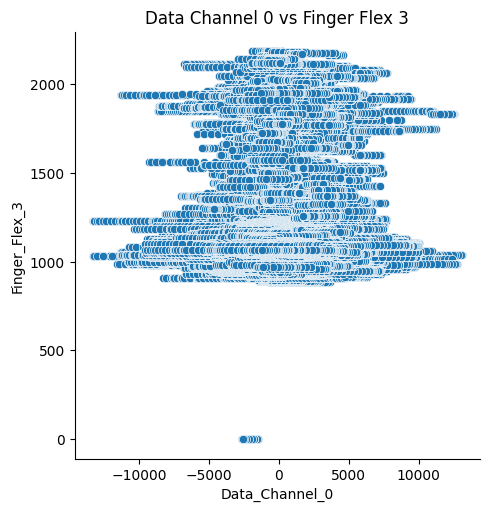

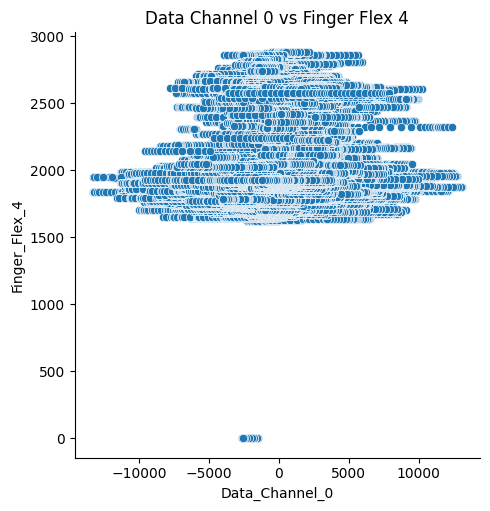

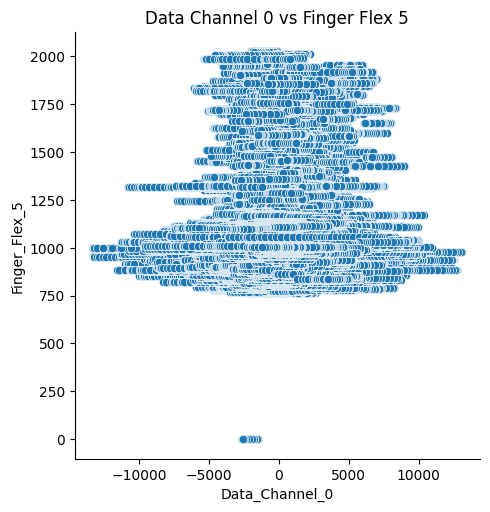

In [37]:
# Check if the number of time points match (assuming this is the primary dimension to compare)
if data.shape[0] == flex.shape[0]:
    # Create a DataFrame to hold the relevant data
    df_combined = pd.DataFrame()

    # Add the first data channel (you can choose a different one if needed)
    df_combined['Data_Channel_0'] = data[:, 0]

    # Add columns for each finger flex value
    for i in range(flex.shape[1]): # Iterate through the finger flex columns
        df_combined[f'Finger_Flex_{i+1}'] = flex[:, i] # Use f-string for cleaner string formatting

    # Now, iterate through the finger flex columns and create plots
    for i in range(flex.shape[1]):
        finger_col_name = f'Finger_Flex_{i+1}'
        # Use this DataFrame with relplot, specifying the columns from your DataFrame
        sns.relplot(data=df_combined, x='Data_Channel_0', y=finger_col_name)
        plt.title(f'Data Channel 0 vs Finger Flex {i+1}') # Add a title for clarity
        plt.show() # Display each plot

else:
    print("Error: 'data' and 'flex' arrays have different numbers of time points.")
    # Handle this case based on your data structure and analysis needs

# Preprocessing

## Step 1: Remove unnecessary columns from bp_fingerflex.mat

In [38]:
import scipy.io

# Load the .mat file
mat = scipy.io.loadmat('bp_fingerflex.mat')

# Keys to delete
keys_to_delete = ['__header__', '__version__', '__globals__', 'brain']

# Delete them if present
for key in keys_to_delete:
    if key in mat:
        del mat[key]

# Now mat only contains the useful keys
print(mat.keys())


dict_keys(['data', 'elec_regions', 'flex', 'locs', 'cue'])


In [39]:
!pip install braindecode

from braindecode.preprocessing import (
    exponential_moving_standardize, preprocess, Preprocessor)

# slow drifts below 1 Hz
low_cut_hz = 1.  # low cut frequency for filtering
# keep high frequency info (rich content in high gamma range (70-200 Hz))
high_cut_hz = 200.  # high cut frequency for filtering, for ECoG higher than for EEG
# Parameters for exponential moving standardization (how fast exponential moving average adapts to new data)
factor_new = 1e-3
# how many samples to use initially for standardization statistics
init_block_size = 1000

from braindecode.preprocessing import Preprocessor, preprocess

# Apply filtering + standardization
preprocessors = [
    Preprocessor('pick_types', eeg=True),  # optional, if data is Raw object
    Preprocessor('filter', l_freq=1., h_freq=200.),  # bandpass filter
    Preprocessor(exponential_moving_standardize,  # standardization
                 factor_new=1e-3, init_block_size=1000)
]

preprocess(dataset, preprocessors)





NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


ValueError: No channels match the selection.

In [40]:
# prompt: apply preprocessor on the dataset i have rn and set it up and everything

# Assuming 'data' loaded from mat and 'stim' loaded from mat1 are your arrays to be preprocessed.
# Also assuming 'data' is your features and 'stim' are your targets.

# Create a dummy dataset structure for demonstration purposes, as preprocess expects a Dataset object
# In a real scenario, you would load your data into a Braindecode compatible Dataset.
# For now, we'll create a structure that mimics what preprocess might work with.

# Let's assume 'data' is your numpy array of shape (n_samples, n_channels)
# and 'stim' is your numpy array of shape (n_samples,).

# Braindecode's preprocess function is designed to work with mne.io.Raw objects
# wrapped in a braindecode.datasets.BaseDataset.
# Since we have numpy arrays, we need to convert them.

import mne
from braindecode.datasets import BaseDataset, BaseConcatDataset # Import BaseConcatDataset
import numpy as np # Ensure numpy is imported
from braindecode.preprocessing import (
    exponential_moving_standardize, preprocess, Preprocessor) # Ensure preprocessors are imported here


# Assuming sfreq (sampling frequency) was determined earlier (e.g., 1000 Hz)
sfreq = 1000.0

# Convert numpy arrays to mne.io.RawArray
# MNE expects data in shape (n_channels, n_times)
data_mne = mne.io.RawArray(data.T, mne.create_info(data.shape[1], sfreq, 'eeg'))

# Stimulus information might be handled as annotations in MNE.
# We need to create annotations from your 'stim' array.
# MNE Annotations need 'onset', 'duration', and 'description'.
# Let's assume each sample in 'stim' corresponds to a time point in 'data_mne'.
# The description will be the stimulus value.

# Find where the stimulus values change or where they are non-zero if 0 means no stimulus
# This part might need adjustment based on how your 'stim' data represents events.
# For simplicity, let's assume every sample is an event with a value.
onsets = np.arange(len(stim)) / sfreq  # time in seconds
# Ensure durations is a 1-dimensional array
durations = np.zeros_like(stim, dtype=float).flatten() # Duration of 0 for point events
# Ensure descriptions is a 1-dimensional array
descriptions = stim.astype(str).flatten() # Use the stimulus value as the description

annotations = mne.Annotations(onset=onsets, duration=durations, description=descriptions)

# Add the annotations to the Raw object
data_mne.set_annotations(annotations)


# Now create a Braindecode BaseDataset from the MNE Raw object
# The target transform specifies how to get the target from the annotations/events.
# For now, we'll include all events as potential trials and the target will be the description.
# You might need a more sophisticated Event or Windows dataset depending on your task.

# Create a minimal dataset structure
# Wrap the single BaseDataset in a BaseConcatDataset
concat_dataset = BaseConcatDataset([BaseDataset(data_mne)])


# Now apply the preprocessors defined previously
# These preprocessors are designed to modify the Raw object within the Dataset.
preprocessors = [
    # Preprocessor('pick_types', eeg=True),  # Use if you have other types of data in Raw
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # bandpass filter
    Preprocessor(exponential_moving_standardize,  # standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

# The preprocess function modifies the dataset in place
preprocess(concat_dataset, preprocessors) # Pass the concatenated dataset

# After this, concat_dataset.datasets[0].raw contains the preprocessed MNE Raw object.
# You can access the preprocessed data as a numpy array like this:
preprocessed_data, times = concat_dataset.datasets[0].raw.get_data(return_times=True)

print("\nPreprocessing applied.")
print("Shape of preprocessed data (channels, times):", preprocessed_data.shape)

# You would typically proceed to create windows from this preprocessed data
# for your machine learning model, which depends on the nature of your task
# (e.g., trial-based classification).

Creating RawArray with float64 data, n_channels=46, n_times=610040
    Range : 0 ... 610039 =      0.000 ...   610.039 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    1.4s finished



Preprocessing applied.
Shape of preprocessed data (channels, times): (46, 610040)


In [42]:
features = concat_dataset.datasets[0].raw.get_data().T  # Shape: (samples, channels)
targets = stim.flatten()  # Or mat1['stim'].flatten(), shape: (samples,)

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    features, targets, test_size=0.2, stratify=targets, random_state=42)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(488032, 46)
(122008, 46)
(488032,)
(122008,)


## Model Creation

In [43]:
# how many time samples model sees at once
# 1 second window
input_window_samples = 1000

import torch
# for reproducibility
from braindecode.util import set_random_seeds
# specialized ConvNet for brain signal decoding
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

# rng reproduced
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

# classification so only want 1 class
n_classes = 5
# Extract number of chans and time steps from dataset
n_chans = x_train.shape[1]
print(n_chans)

#kernal size of final convolutional layer
# smaller the kernal, less temporal context, increased kernal size
model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    final_conv_length=4,
)


# Send model to GPU
if cuda:
    model.cuda()

# dense prediction model - output predictions over time for sliding windows
from braindecode.models import to_dense_prediction_model, get_output_shape



46


/usr/local/lib/python3.11/dist-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [44]:
window_size = 1000  # 1 second bc 1000 Hz sampling rate
stride = 500       # 50% overlap between samples

X = []
y = []

# slides a 500 sample window
for i in range(0, data.shape[0] - window_size, stride):
    eeg_window = data[i:i+window_size, :]   # shape: [500, channels]
    label = stim[i + window_size // 2]    # central label, assuming stim is the target
    X.append(eeg_window)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ShallowConvNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 40, kernel_size=(1, 25), stride=1)
        self.conv2 = nn.Conv2d(40, 40, kernel_size=(X.shape[2], 1))  # spatial filtering
        self.pool = nn.AvgPool2d(kernel_size=(1, 75), stride=(1, 15))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(40 * (X.shape[3] - 99) // 15, n_classes)

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)


In [46]:
# Use the windowed data X and y
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder

# Split the windowed data
# Ensure stratify is possible if classes are imbalanced and not all classes are present in the split.
# If issues arise with stratify due to limited samples of certain classes in the split, remove stratify.
unique_classes, counts = np.unique(y, return_counts=True)
if all(counts >= 2): # Check if each class has at least 2 samples for splitting
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)
else:
     print("Warning: Not enough samples per class for stratification. Splitting without stratify.")
     X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42)

# --- FIX START ---
# Map target labels to be zero-indexed integers
# Use LabelEncoder to handle any range of unique target values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
# Use the encoded labels for the target tensor
y_train_tensor = torch.from_numpy(y_train_encoded).long() # Use long() for classification targets

X_val_tensor = torch.from_numpy(X_val).float()
# Use the encoded labels for the target tensor
y_val_tensor = torch.from_numpy(y_val_encoded).long()

# --- FIX END ---

# Reshape the tensors to (n_samples, 1, n_channels, n_time_steps)
# Original shape of X_train is (n_samples, window_size, n_channels)
# We want (n_samples, 1, n_channels, window_size)
X_train_tensor = X_train_tensor.unsqueeze(1).permute(0, 1, 3, 2)
X_val_tensor = X_val_tensor.unsqueeze(1).permute(0, 1, 3, 2)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define model, loss function, and optimizer
# Make sure n_classes in your model matches the number of unique target values
# Use the number of unique classes after encoding for n_classes
n_classes = len(label_encoder.classes_)

# Adjust the ShallowConvNet's final fully connected layer input size
# based on the new input shape after pooling.
# The input size to the FC layer depends on the output shape of the last pooling layer.
# output_size = floor((input_size - kernel_size) / stride) + 1
# For self.pool = nn.AvgPool2d(kernel_size=(1, 75), stride=(1, 15))
# The input to the pool is (batch, 40, n_channels, window_size)
# After conv2d (kernel_size=(X.shape[2], 1)), the shape is (batch, 40, 1, window_size)
# So the pooling is applied along the time dimension (dim 3).
# The input size along the time dimension is window_size.
# Output size along time dimension after pooling: floor((window_size - 75) / 15) + 1

# Re-define the ShallowConvNet to use the correct input dimensions
class ShallowConvNet(nn.Module):
    def __init__(self, n_classes, n_channels, input_window_samples):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 40, kernel_size=(1, 25), stride=1)
        self.conv2 = nn.Conv2d(40, 40, kernel_size=(n_channels, 1))  # spatial filtering
        self.pool = nn.AvgPool2d(kernel_size=(1, 75), stride=(1, 15))
        self.dropout = nn.Dropout(0.5)

        # Calculate the input size to the FC layer dynamically
        # Simulate forward pass up to the flattening step
        # Input shape: (batch, 1, n_channels, input_window_samples)
        dummy_input = torch.randn(1, 1, n_channels, input_window_samples)
        x = F.elu(self.conv1(dummy_input))
        x = F.elu(self.conv2(x))
        x = self.pool(x)
        fc_input_size = x.view(x.size(0), -1).shape[1]

        self.fc = nn.Linear(fc_input_size, n_classes)

    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)


# Get the number of channels and time points from the windowed data
n_chans = X_train.shape[2] # X_train shape is (n_samples, window_size, n_channels)
window_size = X_train.shape[1] # Use the actual window size from X_train

model = ShallowConvNet(n_classes, n_chans, window_size)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Use CrossEntropyLoss for multi-class

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 10  # Adjust as needed

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        # Reshape labels to be 1D (batch_size,)
        # Use the encoded labels which are already 1D
        loss = criterion(outputs, labels) # Removed .squeeze() as labels are already 1D
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            # Compare predictions with squeezed labels
            # Use the encoded labels which are already 1D
            running_corrects += torch.sum(preds == labels.data) # Removed .squeeze()

    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{n_epochs}, Validation Accuracy: {epoch_acc:.4f}")


print("\nTraining complete.")

# Now you have a trained model. The next steps involve evaluating its performance
# on a separate test set (if available) and using it to predict new data.

# Example of making predictions on the validation set:
model.eval() # Set the model to evaluation mode
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        # Use the original non-encoded labels for evaluation metrics like classification_report
        # This is important to align with the original class meanings (e.g., 0, 1, 2...)
        # However, if you want to evaluate on the encoded labels, use y_val_encoded.
        # For the confusion matrix and classification report, it's usually clearer
        # to use the encoded labels (0, 1, 2...) as they correspond to the model's outputs.
        true_labels.extend(labels.cpu().numpy()) # Use the encoded labels

print("\nMaking predictions on validation data:")
# You can now compare predictions and true_labels to evaluate performance
# e.g., using classification report, confusion matrix from sklearn
from sklearn.metrics import classification_report, confusion_matrix

# If you want the report and confusion matrix to use the original labels (e.g., -2, -1, 0...)
# you would need to inverse transform the predictions.
# Since the model predicts indices (0, 1, 2...), it's more common to evaluate
# based on these predicted indices and the encoded true labels.

print("Classification Report:")
# Use the encoded labels for the classification report
print(classification_report(true_labels, predictions))

print("Confusion Matrix:")
# Use the encoded labels for the confusion matrix
print(confusion_matrix(true_labels, predictions))

Epoch 1/10, Training Loss: 129.9411
Epoch 1/10, Validation Accuracy: 0.0123
Epoch 2/10, Training Loss: 9.5381
Epoch 2/10, Validation Accuracy: 0.0164
Epoch 3/10, Training Loss: 4.5812
Epoch 3/10, Validation Accuracy: 0.1270
Epoch 4/10, Training Loss: 2.5836
Epoch 4/10, Validation Accuracy: 0.1434
Epoch 5/10, Training Loss: 2.0204
Epoch 5/10, Validation Accuracy: 0.3730
Epoch 6/10, Training Loss: 1.9642
Epoch 6/10, Validation Accuracy: 0.3770
Epoch 7/10, Training Loss: 1.9270
Epoch 7/10, Validation Accuracy: 0.3770
Epoch 8/10, Training Loss: 1.9258
Epoch 8/10, Validation Accuracy: 0.3730
Epoch 9/10, Training Loss: 1.8980
Epoch 9/10, Validation Accuracy: 0.3730
Epoch 10/10, Training Loss: 1.9014
Epoch 10/10, Validation Accuracy: 0.3770

Training complete.

Making predictions on validation data:
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       1.00      0.03      0.06        34
          

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
